In [1]:
#%%Importations
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd
import classmail.data_visualisation.data_visualisation as dv
from classmail.nlp.cleaning import clean_body,clean_header
from classmail.classification.trainer import Trainer,Model
from classmail.nlp.df_multiprocessing import apply_parallel

In [49]:
#%%Chargement de nos données : mails santé individuels MAAF
data = pd.read_csv('EXTRACT_MAILS_SANTE_V3_grouped.csv', sep=';', encoding="ANSI")
data.sample(5)

,header,body,COMPETENCE
173,RE : MAAF VOUS REPOND : RE : DEMANDE D'INFORMA...,"Madame,\nVous trouverez ci-joint l'attestation...",EGS Vie du contrat / Cotisations
1042,Remboursement soins,Comme convenu je vous envoie le relevé de la c...,EGS Prestations
2316,rejet facture n°43980,Bonjour suite à notre entretiens téléphonique ...,EGS PS
8234,Votre demande d'attestation,#TYPE_ACTION# : ATT\r\n#ORIGINE# : Espace Web ...,EGS Télétransmission
3873,Honoraire contrôle grossesse,"Bonjour,\r\n\r\nJe vous envoi les frais d'hono...",EGS Prestations


max_length:  23182.0 
min_length:  1.0 
mean:  802.8558369234003 
median:  579.0


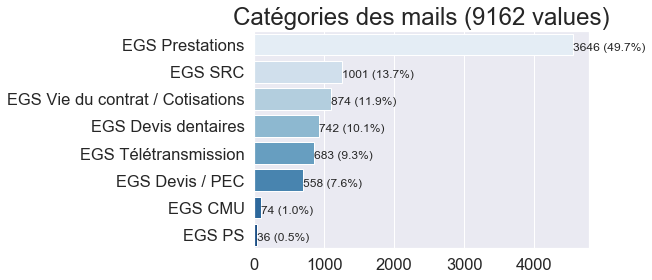

In [5]:
#%%Analyse préliminaire des données
dv.show_string_length(data['body'])
#Répartition des classes
dv.show_class_balancing(data,col_text="body",col_label="COMPETENCE", title="Catégories des mails")

In [6]:
#%%Nettoyage des données
start = time.time()

data['cleaned_body'] = apply_parallel(data, clean_body)
data['cleaned_header'] = apply_parallel(data, clean_header)

#Regroupement de l'objet et du corps du mail
data["clean_text"] = data['cleaned_header'] + " " + data['cleaned_body']

end = time.time()
print("Durée du traitement :", round(end - start), "s")

#On a seulement besoin du mail et du label pour la suite !
data_cleaned = data[["clean_text","COMPETENCE"]]

Durée du traitement : 19 s


max_length:  5251 
min_length:  1 
mean:  176.69375128892554 
median:  131.0

__________________________________________________

Before : 
 Remboursement de la cotisation d avril
Bonjour,

Pourriez vous m'informer dans quel delai me parviendra le remboursement du moi d'avril de la mutuelle que j avais souscrite chez maaf?
Merci
Cordialement

Télécharger Outlook pour Android<https://aka.ms/ghei36> 

______________________________________

 After :
 remboursement cotisation avril pourriez informer delai parviendra remboursement flagdate mutuelle souscrite

__________________________________________________

Avant :


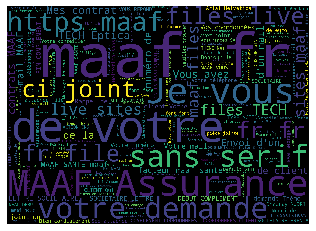

Après :


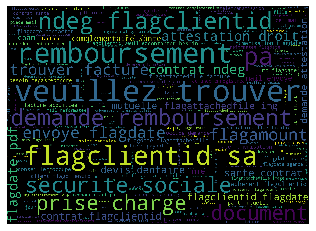

In [45]:
#%%Visualisation des données nettoyées
#Regroupement du header et du body sur les données non nettoyées
data['dirty_text'] = data['header'].astype(str) + "\n" +data['body'].astype(str) 

#Taille des textes
dv.show_string_length(data_cleaned['clean_text'])
print("\n__________________________________________________\n")

#Textes avant / après
dv.show_before_after(data['dirty_text'], data_cleaned['clean_text'], index=31)
print("\n__________________________________________________\n")


# Wordclouds avant/après
print("Avant :")
dv.show_wordcloud(data, 'dirty_text')
print("Après :")
dv.show_wordcloud(data_cleaned, 'clean_text')

In [20]:
#%%Préparation des données : création des csv en vue de l'entraînement du modèle
trainer = Trainer()
#Il est nécessaire de renseigner le nom des colonnes de texte (mail nettoyé ici) et de label (la "compétence" ici)
trainer.prepare_data(data_cleaned, text_col="clean_text",
                     label_col="COMPETENCE")

Old number of rows:  9698
New number of rows:  9683
Train, test and val csv files were created in .\ressources !


In [21]:
#%%Entraînement : les modèles (PyTorch) utilisés sont ceux de l'excellente bibliothèque Flair : https://github.com/zalandoresearch/flair
#Ainsi, les modèles suivent perpetuellement l'état de l'art
start = time.time()

#Entraînement avec les paramètres par défaut :
trainer.train_model(model_name="mails_grouped_fasttext")

#Des paramètres supplémentaires peuvent être renseignés :
#trainer.train_model(model_name="mails_grouped_fasttext", batch_size=16, rnn_type="GRU",hidden_size=64,patience=2,learning_rate=1e-3)

#Il est possible d'utiliser la classe DocumentPoolEmbeddings de Flair pour l'entraînement. En général celui-ci sera plus rapide :
trainer.train_model(model_name="mails_grouped_fasttext", use_pool_embedding=True)

end = time.time()
print("Training took: ",round((end - start)/60,1), "min")
#53min sans pooling
#37min avec pooling (résultats légèrement moins bons)

2019-08-01 13:57:10,546 Reading data from ressources
2019-08-01 13:57:10,552 Train: ressources\train.csv
2019-08-01 13:57:10,555 Dev: ressources\dev.csv
2019-08-01 13:57:10,558 Test: ressources\test.csv
2019-08-01 13:57:10,650 Computing label dictionary. Progress:


100%|████████████████████████████████████| 6778/6778 [00:03<00:00, 1776.96it/s]


2019-08-01 13:57:30,133 [b'EGS Prestations', b'EGS Devis / PEC', b'EGS CMU', b'EGS Vie du contrat / Cotisations', b'EGS Teletransmission', b'EGS Devis dentaires', b'EGS SRC', b'EGS PS']
2019-08-01 13:57:30,139 this function is deprecated, use smart_open.open instead
2019-08-01 13:58:06,912 ----------------------------------------------------------------------------------------------------
2019-08-01 13:58:06,915 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('fr')
    )
    (word_reprojection_map): Linear(in_features=300, out_features=128, bias=True)
    (rnn): GRU(128, 16)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Linear(in_features=16, out_features=8, bias=True)
  (loss_function): CrossEntropyLoss()
)"
2019-08-01 13:58:06,917 ----------------------------------------------------------------------------------------------------
2019-08-01 13:58:06,921 Corpus: "Corpus: 6778 train +

2019-08-01 14:05:31,154 epoch 6 - iter 420/848 - loss 0.91509534
2019-08-01 14:05:35,810 epoch 6 - iter 504/848 - loss 0.91714263
2019-08-01 14:05:40,301 epoch 6 - iter 588/848 - loss 0.91325133
2019-08-01 14:05:46,515 epoch 6 - iter 672/848 - loss 0.91527458
2019-08-01 14:05:52,920 epoch 6 - iter 756/848 - loss 0.91326682
2019-08-01 14:05:58,859 epoch 6 - iter 840/848 - loss 0.90502704
2019-08-01 14:06:00,155 ----------------------------------------------------------------------------------------------------
2019-08-01 14:06:00,158 EPOCH 6 done: loss 0.9048 - lr 0.0010
2019-08-01 14:06:12,299 DEV : loss 0.7986266613006592 - score 0.7169
2019-08-01 14:06:13,346 BAD EPOCHS (no improvement): 1
2019-08-01 14:06:13,348 ----------------------------------------------------------------------------------------------------
2019-08-01 14:06:20,985 epoch 7 - iter 0/848 - loss 0.94588375
2019-08-01 14:06:25,584 epoch 7 - iter 84/848 - loss 0.85899573
2019-08-01 14:06:29,599 epoch 7 - iter 168/848 

2019-08-01 14:16:08,472 epoch 13 - iter 588/848 - loss 0.81933377
2019-08-01 14:16:13,369 epoch 13 - iter 672/848 - loss 0.81984824
2019-08-01 14:16:18,106 epoch 13 - iter 756/848 - loss 0.82398998
2019-08-01 14:16:22,595 epoch 13 - iter 840/848 - loss 0.82405299
2019-08-01 14:16:23,493 ----------------------------------------------------------------------------------------------------
2019-08-01 14:16:23,496 EPOCH 13 done: loss 0.8225 - lr 0.0010
2019-08-01 14:16:35,853 DEV : loss 0.7637753486633301 - score 0.7293
2019-08-01 14:16:36,961 BAD EPOCHS (no improvement): 1
2019-08-01 14:16:36,964 ----------------------------------------------------------------------------------------------------
2019-08-01 14:16:44,759 epoch 14 - iter 0/848 - loss 1.05849493
2019-08-01 14:16:49,258 epoch 14 - iter 84/848 - loss 0.82800163
2019-08-01 14:16:54,872 epoch 14 - iter 168/848 - loss 0.81087003
2019-08-01 14:17:00,433 epoch 14 - iter 252/848 - loss 0.81443983
2019-08-01 14:17:05,251 epoch 14 - ite

2019-08-01 14:24:57,952 epoch 20 - iter 672/848 - loss 0.76350850
2019-08-01 14:25:02,513 epoch 20 - iter 756/848 - loss 0.75882134
2019-08-01 14:25:07,575 epoch 20 - iter 840/848 - loss 0.75647261
2019-08-01 14:25:08,475 ----------------------------------------------------------------------------------------------------
2019-08-01 14:25:08,477 EPOCH 20 done: loss 0.7587 - lr 0.0005
2019-08-01 14:25:19,332 DEV : loss 0.7698150277137756 - score 0.739
2019-08-01 14:25:20,396 BAD EPOCHS (no improvement): 1
2019-08-01 14:25:20,398 ----------------------------------------------------------------------------------------------------
2019-08-01 14:25:27,476 epoch 21 - iter 0/848 - loss 0.28672916
2019-08-01 14:25:32,555 epoch 21 - iter 84/848 - loss 0.75117017
2019-08-01 14:25:37,458 epoch 21 - iter 168/848 - loss 0.77438989
2019-08-01 14:25:43,313 epoch 21 - iter 252/848 - loss 0.77000125
2019-08-01 14:25:51,001 epoch 21 - iter 336/848 - loss 0.76006391
2019-08-01 14:25:56,852 epoch 21 - iter

2019-08-01 14:33:25,067 epoch 27 - iter 672/848 - loss 0.70881439
2019-08-01 14:33:30,406 epoch 27 - iter 756/848 - loss 0.71253453
2019-08-01 14:33:36,039 epoch 27 - iter 840/848 - loss 0.71274460
2019-08-01 14:33:36,940 ----------------------------------------------------------------------------------------------------
2019-08-01 14:33:36,943 EPOCH 27 done: loss 0.7107 - lr 0.0001
2019-08-01 14:33:49,441 DEV : loss 0.7756502628326416 - score 0.739
2019-08-01 14:33:50,500 BAD EPOCHS (no improvement): 2
2019-08-01 14:33:50,502 ----------------------------------------------------------------------------------------------------
2019-08-01 14:33:58,481 epoch 28 - iter 0/848 - loss 0.72958148
2019-08-01 14:34:02,608 epoch 28 - iter 84/848 - loss 0.71076982
2019-08-01 14:34:06,892 epoch 28 - iter 168/848 - loss 0.70676226
2019-08-01 14:34:12,401 epoch 28 - iter 252/848 - loss 0.71640401
2019-08-01 14:34:17,261 epoch 28 - iter 336/848 - loss 0.73016406
2019-08-01 14:34:22,895 epoch 28 - iter

100%|████████████████████████████████████| 6778/6778 [00:04<00:00, 1489.19it/s]


2019-08-01 14:36:27,137 [b'EGS Prestations', b'EGS Devis / PEC', b'EGS CMU', b'EGS Vie du contrat / Cotisations', b'EGS Teletransmission', b'EGS Devis dentaires', b'EGS SRC', b'EGS PS']
2019-08-01 14:36:27,150 this function is deprecated, use smart_open.open instead
2019-08-01 14:36:33,504 ----------------------------------------------------------------------------------------------------
2019-08-01 14:36:33,506 Model: "TextClassifier(
  (document_embeddings): DocumentPoolEmbeddings(
    fine_tune_mode=nonlinear, pooling=max
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('fr')
    )
    (embedding_flex): Linear(in_features=300, out_features=300, bias=False)
    (embedding_flex_nonlinear): ReLU(inplace)
    (embedding_flex_nonlinear_map): Linear(in_features=300, out_features=300, bias=True)
  )
  (decoder): Linear(in_features=300, out_features=8, bias=True)
  (loss_function): CrossEntropyLoss()
)"
2019-08-01 14:36:33,511 -----------------------------------

2019-08-01 14:41:42,393 epoch 6 - iter 252/848 - loss 0.33114483
2019-08-01 14:41:45,077 epoch 6 - iter 336/848 - loss 0.35578090
2019-08-01 14:41:47,792 epoch 6 - iter 420/848 - loss 0.35623394
2019-08-01 14:41:50,677 epoch 6 - iter 504/848 - loss 0.37006456
2019-08-01 14:41:53,722 epoch 6 - iter 588/848 - loss 0.37468518
2019-08-01 14:41:56,382 epoch 6 - iter 672/848 - loss 0.37485616
2019-08-01 14:41:59,183 epoch 6 - iter 756/848 - loss 0.38520975
2019-08-01 14:42:02,197 epoch 6 - iter 840/848 - loss 0.38798723
2019-08-01 14:42:02,988 ----------------------------------------------------------------------------------------------------
2019-08-01 14:42:02,991 EPOCH 6 done: loss 0.3880 - lr 0.0010
2019-08-01 14:42:13,718 DEV : loss 0.8943096399307251 - score 0.7335
Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
2019-08-01 14:42:14,726 BAD EPOCHS (no improvement): 3
2019-08-01 14:42:14,728 -----------------------------------------------------------------------------------

2019-08-01 14:47:07,729 epoch 13 - iter 168/848 - loss 0.08149401
2019-08-01 14:47:10,276 epoch 13 - iter 252/848 - loss 0.08063193
2019-08-01 14:47:12,804 epoch 13 - iter 336/848 - loss 0.08398773
2019-08-01 14:47:15,417 epoch 13 - iter 420/848 - loss 0.07932265
2019-08-01 14:47:18,164 epoch 13 - iter 504/848 - loss 0.08260158
2019-08-01 14:47:21,419 epoch 13 - iter 588/848 - loss 0.08207380
2019-08-01 14:47:24,144 epoch 13 - iter 672/848 - loss 0.07934440
2019-08-01 14:47:26,778 epoch 13 - iter 756/848 - loss 0.08086486
2019-08-01 14:47:29,454 epoch 13 - iter 840/848 - loss 0.07919478
2019-08-01 14:47:30,154 ----------------------------------------------------------------------------------------------------
2019-08-01 14:47:30,156 EPOCH 13 done: loss 0.0798 - lr 0.0001
2019-08-01 14:47:40,695 DEV : loss 1.0895394086837769 - score 0.7342
2019-08-01 14:47:41,747 BAD EPOCHS (no improvement): 1
2019-08-01 14:47:41,749 ----------------------------------------------------------------------

In [25]:
#%%Chargement des données de test et du model
data_test = pd.read_csv('ressources/test.csv', sep=',', encoding="utf-8")
X_test = data_test["clean_text"]
labels_test = data_test["COMPETENCE"]

model = Model("ressources\\grouped_fasttext_29-07")

#Prédictions sur les données de test 
predictions,confidence=model.predict(X_test,get_confidence=True)

2019-08-01 15:03:38,813 loading file ressources\grouped_fasttext_29-07\final-model.pt


In [71]:
#%%Affichage de quelques prédiction
for i in range(165,170):
    print("Label prédit :", predictions[i],confidence[i])
    print("Vrai label :", labels_test[i],"\n")

Label prédit : EGS Prestations (0.9836800694465637)
Vrai label : EGS Prestations 

Label prédit : EGS Devis dentaires (0.9502057433128357)
Vrai label : EGS Prestations 

Label prédit : EGS Prestations (0.4933408498764038)
Vrai label : EGS Prestations 

Label prédit : EGS Teletransmission (0.33924874663352966)
Vrai label : EGS Vie du contrat / Cotisations 

Label prédit : EGS Prestations (0.7754471302032471)
Vrai label : EGS Prestations 



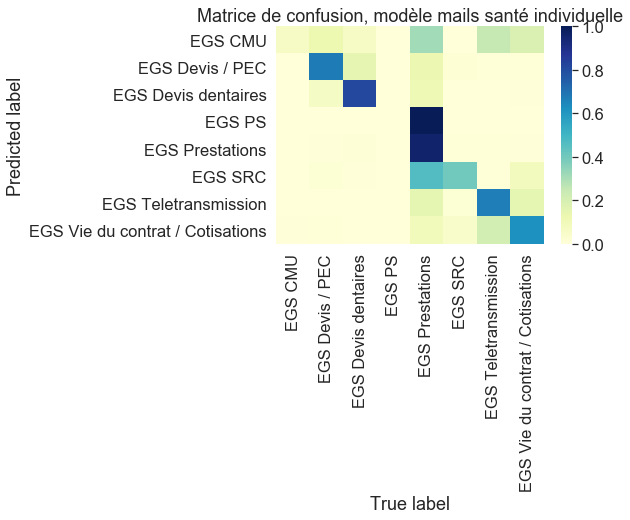

Accuracy: 0.7763248451479697
F1-score: 0.7934025666722017
Precision: 0.8265036534485701
Recall: 0.7763248451479697


In [28]:
#%%Visualisation des résultats 
#Matrice de confusion
dv.show_confusion_matrix(pred_labels=predictions, true_labels=labels_test, title="Matrice de confusion, modèle mails santé individuelle")

#Métriques d'évaluation du modèle
dv.get_metrics(pred_labels=predictions, true_labels=labels_test,average="weighted")

#On peut également calculer les macro précision/rappel/F1 mais dans le cadre de ce problème, certaines classes étant sous
#représentés on peut s'attendre à de moins bons résultats
#Pour plus d'info sur le paramètre average : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#dv.get_metrics(pred_labels=predictions, true_labels=labels_test,average="macro")


In [48]:
#%%Génération d'un dataframe permettant d'analyser les résultats
results = dv.generate_preds_true_df(X_test,predictions,labels_test, confidence=confidence)
#Il est possible d'exporter directement le dataframe dans un fichier csv : 
results = dv.generate_preds_true_df(X_test,predictions,labels_test, confidence=confidence, export_to="resultats.csv")
results.sample(5)

,Text,Prediction,True label,Good prediction,Prediction confidence
#,,,,,
381,annulation teletransmission cpam minodier mart...,EGS Teletransmission,EGS Teletransmission,True,0.7250892519950867
128,attestation sante contrat ndeg flagclientid sa...,EGS Prestations,EGS Prestations,True,0.6954978108406067
105,attestation veuillez trouver decomptes fille g...,EGS Teletransmission,EGS Prestations,False,0.4674581289291382
68,mise place teletransmission faire suite courri...,EGS Teletransmission,EGS Teletransmission,True,0.6004072427749634
244,votre demande attestation type action att espa...,EGS Teletransmission,EGS Teletransmission,True,0.5631780624389648
